In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler

from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve

In [2]:
import plotly
import kaleido

In [3]:
#%% Function to extract code from GitHub:
import requests

def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__ML_usefull = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/04_Python_ML.py'
GetGitHubCode(GitUrl__ML_usefull)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
def plot_confusion_matrix(y_test, y_hat, model, class_names):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(12,10))
    disp.plot(ax=ax)
    plt.rcParams["font.size"] = "11"
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.show()

In [6]:
def mulit_class_results_df(model_fitted, pred_proba):
    
    '''
    return 2 df, 1-st with sorted pred_proba
               , second with sorted labels related to probas
    '''
    
    
    top_n_lables_idx = np.argsort(-pred_proba, axis=1)
    top_n_probs = np.round(-np.sort(-pred_proba),3)
    #top_n_lables_idx = np.argsort(-pred_proba, axis=1)[:, :n]
    #top_n_probs = np.round(-np.sort(-pred_proba),3)[:, :n]
    top_n_labels = [model_fitted.classes_[i] for i in top_n_lables_idx]

    #results = list(zip(top_n_labels, top_n_probs))
    # pd.DataFrame(results, columns = ['labels_sorted', 'prob_sorted'])
    
    return pd.DataFrame(top_n_probs), pd.DataFrame(top_n_labels)

In [7]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\loT_intrusion_detection')

In [8]:
###################
#%% Read data
###################

In [9]:
analysis_data = pd.read_csv('analysis_data_IoT_Intrusion.csv')                          

In [10]:
# extract mapping values
maping_labals = analysis_data[['attact_type_main_num', 'attact_type_main']]\
                    .drop_duplicates()\
                    .sort_values('attact_type_main_num')

maping_labals = dict(zip(maping_labals['attact_type_main_num'],maping_labals['attact_type_main']))

maping_labals

{0: 'Benign',
 1: 'BruteForce',
 2: 'DDoS',
 3: 'DoS',
 4: 'Mirai',
 5: 'Recon',
 6: 'Spoofing',
 7: 'Web'}

In [11]:
analysis_data.drop('attact_type_main', axis=1, inplace=True)

In [12]:
##########################################################
##########################################################
#%% Analysis data - prepare for analysis
##########################################################
##########################################################

In [13]:
##########################################################
#%% Train-Test Set

In [14]:
y_name = 'attact_type_main_num'

In [15]:
X = analysis_data.drop(y_name, axis=1)
y = analysis_data[[y_name]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# stratify=y garantie the same 'y' distribution

In [16]:
##########################################################
#%% Undersampling training data

<AxesSubplot:xlabel='attact_type_main_num'>

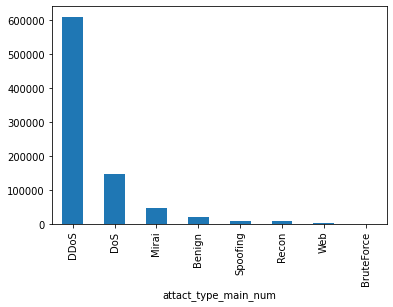

In [17]:
y_train[y_name].replace(maping_labals).value_counts().plot(kind='bar')

In [18]:
y_train[y_name].replace(maping_labals).value_counts()

attact_type_main_num
DDoS          610820
DoS           145185
Mirai          47387
Benign         19581
Spoofing        8842
Recon           6356
Web              430
BruteForce       259
Name: count, dtype: int64

In [19]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

In [20]:
desired_level = 19581
resample_df = []


for label in X_y_train.attact_type_main_num.unique():
    df_for_label = X_y_train.query(f'{y_name} == @label')
    if len(df_for_label) >= desired_level:
        resample_df.append( df_for_label.sample(desired_level) )
    else:
        resample_df.append( df_for_label )

resample_df = pd.concat(resample_df)

print(resample_df[y_name].value_counts())

attact_type_main_num
2    19581
3    19581
0    19581
4    19581
6     8842
5     6356
7      430
1      259
Name: count, dtype: int64


In [21]:
X_train = resample_df.drop(y_name, axis=1)
y_train = resample_df[[y_name]]

In [22]:
# # define underampler
# rus = RandomUnderSampler(random_state=0)
#
# # fit random-under-sampler
# rus.fit(X_train, y_train)
#
# # make resampling
# X_train, y_train = rus.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='attact_type_main_num'>

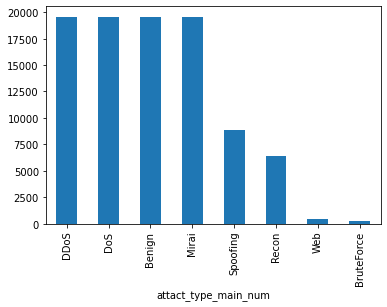

In [23]:
y_train[y_name].replace(maping_labals).value_counts().plot(kind='bar')

In [24]:
##########################################################
#%% scale data for some models

In [25]:
X_train_sld = StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test_sld = StandardScaler().fit(X_test).transform(X_test.astype(float))

In [26]:
##########################################################
##########################################################
#%% ANN
##########################################################
##########################################################

In [27]:
# one-hot encoding y data

yohe = np_utils.to_categorical(y)
yohe_train = np_utils.to_categorical(y_train)
yohe_test = np_utils.to_categorical(y_test)

In [28]:
# Define parameters set
ann_param_grid = dict(epochs = [10,20,30,50,70,90,110],
                      batch_size = [10,20,40, 60,80],
                      model__loss = ['categorical_crossentropy'],
                      model__optimizer = ['adam','nadam'],
                      model__neurons_nr = [25, 50, 150, 200, 250],
                      model__hidden_layers_nr = [1,2,3,4,5],
                      model__input_shape = [(X_train_sld.shape[1], )],
                      model__output_nodes_nr = [8],                      
                      model__add_batch_norm = [False, True],
                      model__activation_fun = ['relu', 'LeakyReLU', 'ELU', 'swish'],
                      model__activation_out = ['softmax'],
                      model__dropout = [0.0, 0.1, 0.2, 0.3],
                      model__init = ['glorot_uniform','normal'],
                      model__regression_type = [False])

In [29]:
# Define wrapper
wraped_ann_model = KerasClassifier(model = create_feed_forward_model)

# Search hyperparamers
model_ann_random_search = RandomizedSearchCV(param_distributions = ann_param_grid,
                                            estimator = wraped_ann_model,
                                            scoring = ['f1_macro','accuracy', 'roc_auc_ovr', 'recall'],
                                            refit = 'f1_macro',
                                            n_iter = 50,
                                            cv = 4,
                                            verbose=1,
                                            n_jobs=-1)

model_ann_random_search.fit( X_train_sld, yohe_train )

# Print the best parameters
print("Best parameters found: ", model_ann_random_search.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


C:\Users\kamil\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/70
4711/4711 [==============================] - 17s 3ms/step - loss: 0.4965 - accuracy: 0.7878 - auc: 0.9802
Epoch 2/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4369 - accuracy: 0.8056 - auc: 0.9842
Epoch 3/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4240 - accuracy: 0.8125 - auc: 0.9852
Epoch 4/70
4711/4711 [==============================] - 21s 4ms/step - loss: 0.4164 - accuracy: 0.8140 - auc: 0.9856
Epoch 5/70
4711/4711 [==============================] - 22s 5ms/step - loss: 0.4084 - accuracy: 0.8175 - auc: 0.9861
Epoch 6/70
4711/4711 [==============================] - 22s 5ms/step - loss: 0.4042 - accuracy: 0.8184 - auc: 0.9864
Epoch 7/70
4711/4711 [==============================] - 24s 5ms/step - loss: 0.3990 - accuracy: 0.8210 - auc: 0.9867
Epoch 8/70
4711/4711 [==============================] - 22s 5ms/step - loss: 0.3959 - accuracy: 0.8226 - auc: 0.9869
Epoch 9/70
4711/4711 [==============================] - 22s 5ms/

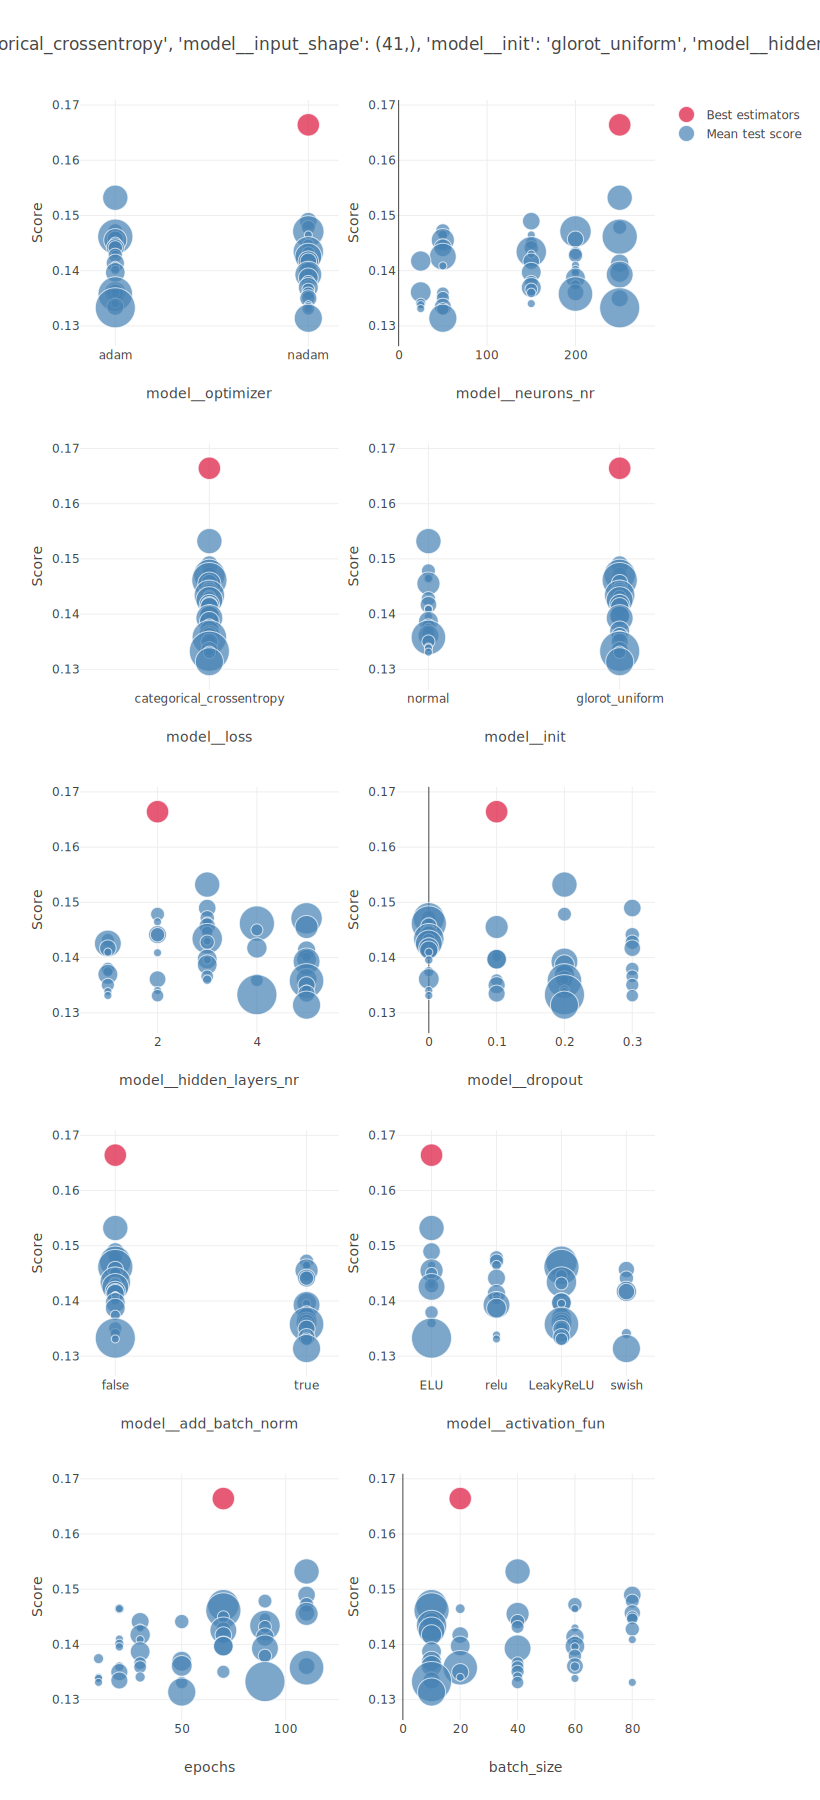

In [77]:
# plot parameters and scores
plot_grid_search_few_score(model_ann_random_search, for_github = True, score_name = 'f1_macro')

In [31]:
# Extract the best model
model_ann = model_ann_random_search.best_estimator_

In [32]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [33]:
preds_ann = np.argmax(model_ann.predict(X_test_sld), axis=1)
predict_proba_ann = model_ann.predict_proba(X_test_sld)

preds_df_ann = pd.DataFrame(preds_ann, columns = ['y_hat'])

10486/10486 [==============================] - 14s 1ms/step


              precision    recall  f1-score   support

      Benign       0.75      0.71      0.73      4895
  BruteForce       1.00      0.23      0.38        65
        DDoS       1.00      0.17      0.29    152705
         DoS       0.26      0.39      0.31     36296
       Mirai       0.15      1.00      0.26     11846
       Recon       0.06      0.48      0.10      1589
    Spoofing       0.05      0.76      0.10      2211
         Web       0.31      0.04      0.07       108

    accuracy                           0.28    209715
   macro avg       0.45      0.47      0.28    209715
weighted avg       0.80      0.28      0.30    209715


AUC score:   0.828

Confusion Matrix:


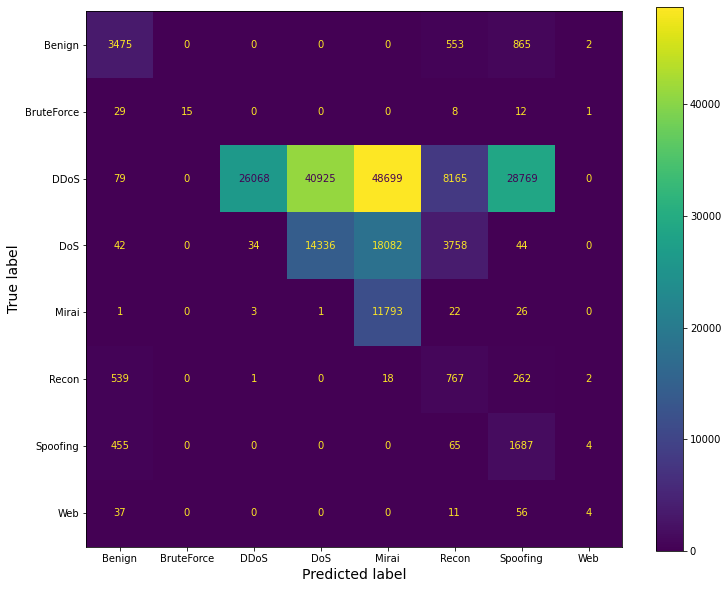

In [34]:
# Print the classification report
print(classification_report(y_test, preds_df_ann , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_ann, multi_class='ovr', average="macro"), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_ann, model_ann, list(maping_labals.values())) 

In [ ]:
##########################################################
##########################################################
#%% ANN - fewer elements
##########################################################
##########################################################

In [55]:
desired_level = 1000
resample_df = []


for label in X_y_train.attact_type_main_num.unique():
    df_for_label = X_y_train.query(f'{y_name} == @label')
    if len(df_for_label) >= desired_level:
        resample_df.append( df_for_label.sample(desired_level) )
    else:
        resample_df.append( df_for_label )

resample_df = pd.concat(resample_df)

print(resample_df[y_name].value_counts())

attact_type_main_num
2    1000
3    1000
0    1000
5    1000
4    1000
6    1000
7     430
1     259
Name: count, dtype: int64


In [58]:
X_train_02 = resample_df.drop(y_name, axis=1)
y_train_02 = resample_df[[y_name]]

<AxesSubplot:xlabel='attact_type_main_num'>

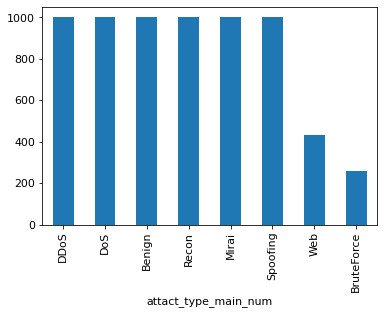

In [59]:
y_train_02[y_name].replace(maping_labals).value_counts().plot(kind='bar')

In [60]:
X_train_02_sld = StandardScaler().fit(X_train_02).transform(X_train_02.astype(float))

In [61]:
# one-hot encoding y data

yohe_train_02 = np_utils.to_categorical(y_train_02)

In [72]:
# Define parameters set
ann_param_grid_02 = dict(epochs = [10,20,30,50,70,90,110],
                          batch_size = [10,20,40, 60,80],
                          model__loss = ['categorical_crossentropy'],
                          model__optimizer = ['adam','nadam'],
                          model__neurons_nr = [25, 50, 150, 200, 250, 300, 350, 400],
                          model__hidden_layers_nr = [1,2,3,4,5,7, 9],
                          model__input_shape = [(X_train_sld.shape[1], )],
                          model__output_nodes_nr = [8],                      
                          model__add_batch_norm = [False, True],
                          model__activation_fun = ['relu', 'LeakyReLU', 'ELU', 'swish'],
                          model__activation_out = ['softmax'],
                          model__dropout = [0.0, 0.1, 0.2, 0.3, 0.4],
                          model__init = ['glorot_uniform','normal'],
                          model__regression_type = [False])

In [73]:
# Define wrapper
wraped_ann_model = KerasClassifier(model = create_feed_forward_model)

# Search hyperparamers
model_ann_random_search_02 = RandomizedSearchCV(param_distributions = ann_param_grid_02,
                                                estimator = wraped_ann_model,
                                                scoring = ['f1_macro','accuracy', 'roc_auc_ovr', 'recall'],
                                                refit = 'f1_macro',
                                                n_iter = 150,
                                                cv = 4,
                                                verbose=1,
                                                n_jobs=-1)

model_ann_random_search_02.fit( X_train_02_sld, yohe_train_02 )

# Print the best parameters
print("Best parameters found: ", model_ann_random_search_02.best_params_)

Fitting 4 folds for each of 150 candidates, totalling 600 fits


C:\Users\kamil\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]



Epoch 1/50
669/669 [==============================] - 6s 5ms/step - loss: 1.2704 - accuracy: 0.4956 - auc: 0.8846
Epoch 2/50
669/669 [==============================] - 4s 5ms/step - loss: 1.0325 - accuracy: 0.5741 - auc: 0.9222
Epoch 3/50
669/669 [==============================] - 4s 5ms/step - loss: 0.9834 - accuracy: 0.5904 - auc: 0.9290
Epoch 4/50
669/669 [==============================] - 4s 5ms/step - loss: 0.9504 - accuracy: 0.5892 - auc: 0.9326
Epoch 5/50
669/669 [==============================] - 4s 5ms/step - loss: 0.9432 - accuracy: 0.5917 - auc: 0.9341
Epoch 6/50
669/669 [==============================] - 5s 7ms/step - loss: 0.9192 - accuracy: 0.5959 - auc: 0.9370
Epoch 7/50
669/669 [==============================] - 4s 5ms/step - loss: 0.9137 - accuracy: 0.5950 - auc: 0.9376
Epoch 8/50
669/669 [==============================] - 4s 6ms/step - loss: 0.9183 - accuracy: 0.5950 - auc: 0.9374
Epoch 9/50
669/669 [==============================] - 3s 5ms/step - loss: 0.8827 - accur

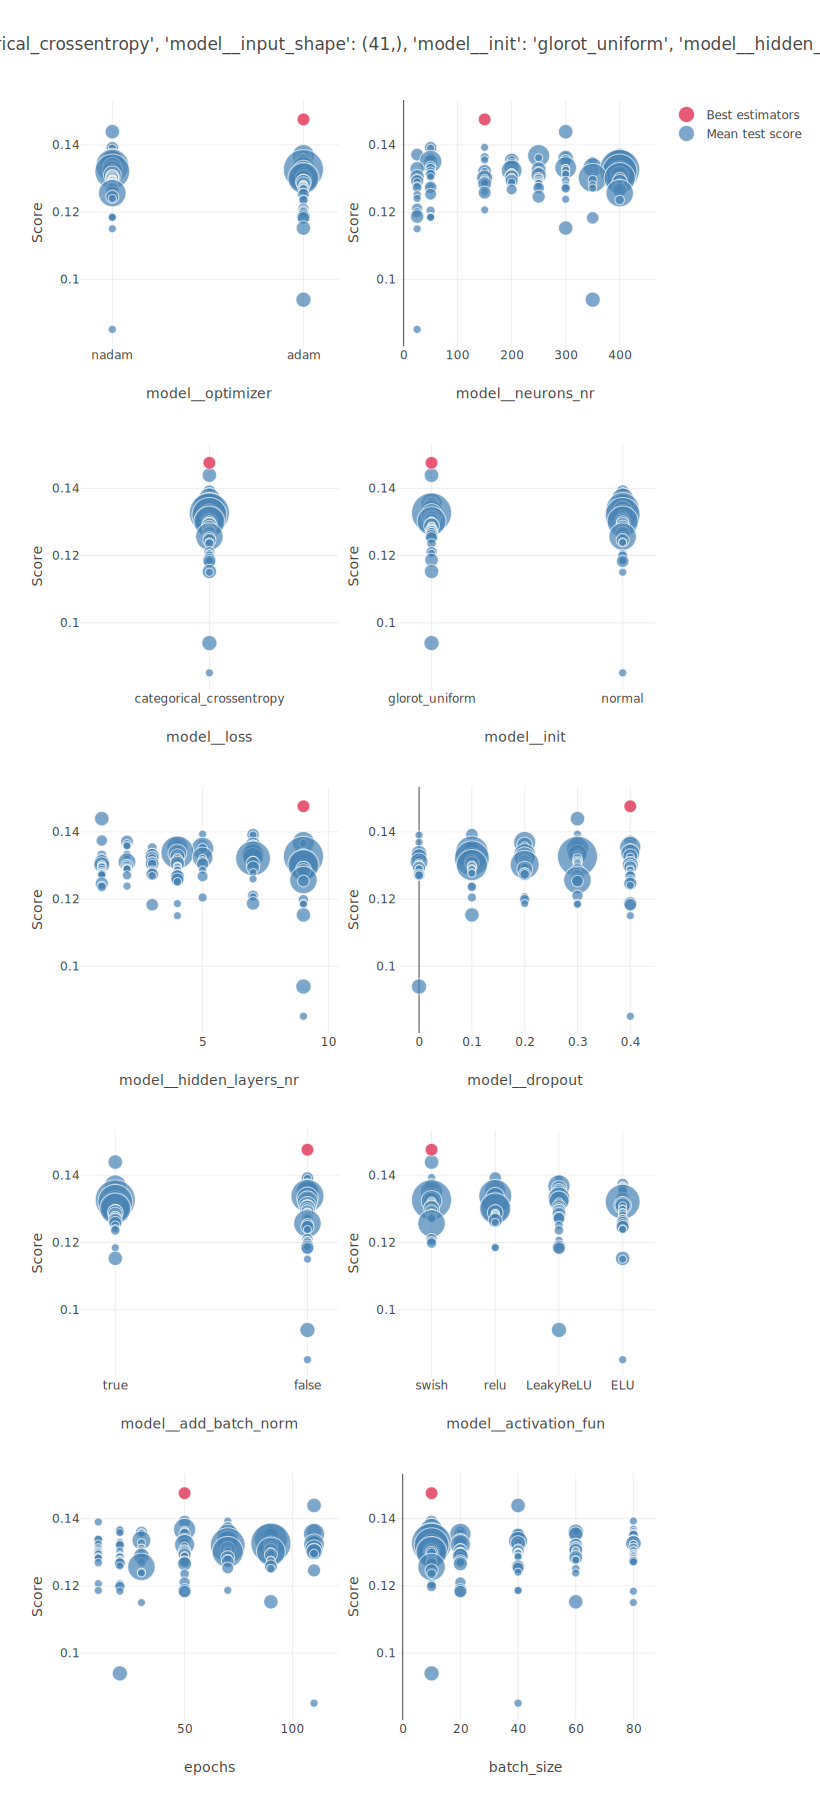

In [78]:
# plot parameters and scores
plot_grid_search_few_score(model_ann_random_search_02, for_github = True, score_name = 'f1_macro')

In [69]:
# Extract the best model
model_ann_02 = model_ann_random_search_02.best_estimator_

In [ ]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [70]:
preds_ann_02 = np.argmax(model_ann_02.predict(X_test_sld), axis=1)
predict_proba_ann_02 = model_ann_02.predict_proba(X_test_sld)

preds_df_ann_02 = pd.DataFrame(preds_ann_02, columns = ['y_hat'])

20972/20972 [==============================] - 46s 2ms/step


              precision    recall  f1-score   support

      Benign       0.60      0.79      0.68      4895
  BruteForce       1.00      0.23      0.38        65
        DDoS       1.00      0.40      0.57    152705
         DoS       0.26      0.75      0.38     36296
       Mirai       0.03      0.01      0.01     11846
       Recon       0.04      0.49      0.07      1589
    Spoofing       0.10      0.61      0.17      2211
         Web       0.00      0.00      0.00       108

    accuracy                           0.45    209715
   macro avg       0.38      0.41      0.28    209715
weighted avg       0.79      0.45      0.50    209715


AUC score:   0.878

Confusion Matrix:


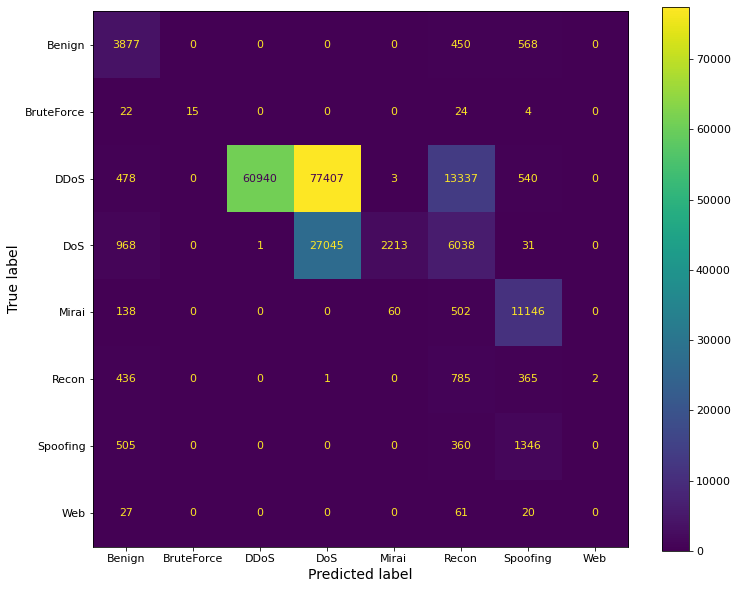

In [71]:
# Print the classification report
print(classification_report(y_test, preds_df_ann_02 , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_ann_02, multi_class='ovr', average="macro"), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_ann_02, model_ann_02, list(maping_labals.values())) 

In [74]:
 pd.DataFrame(model_ann_random_search_02.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__regression_type,param_model__output_nodes_nr,param_model__optimizer,param_model__neurons_nr,param_model__loss,param_model__input_shape,...,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,2362.926874,5.987446,9.419903,4.042011,False,8,adam,350,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
1,576.212938,6.317495,13.189769,0.656594,False,8,nadam,25,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
2,351.443784,4.165815,13.002606,0.441761,False,8,adam,25,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
3,80.821775,1.282370,5.878921,0.379395,False,8,nadam,150,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
4,647.502550,3.816235,15.113382,0.306449,False,8,adam,250,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,164.783614,8.543026,3.881809,0.921734,False,8,nadam,150,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
146,52.743873,12.137483,3.091927,2.030871,False,8,nadam,400,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
147,484.617765,12.770805,1.673658,0.534801,False,8,nadam,250,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
148,284.913640,22.345370,4.247956,1.725415,False,8,nadam,350,categorical_crossentropy,"(41,)",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1


In [75]:
model_ann_random_search_02.cv_results_

{'mean_fit_time': array([2362.92687422,  576.21293783,  351.44378406,   80.82177544,
         647.50255007,   76.56861418,  118.32945025,  200.24153399,
         225.56018162,   90.31816334,   83.18853849,   47.98788619,
         468.40983438,  379.43598622,  116.09497589,   74.01744223,
         890.25156277,   99.08063293,  249.98488265,  130.86716485,
         206.31388426,  175.61917025,  188.13713694,  122.82946122,
         302.18433928,  164.22389185,   79.44321162,  459.37432307,
          23.10417372,  144.12373388,  251.3092373 ,  443.28658831,
         123.9031927 ,  570.38327163,  142.27356601,  113.5057435 ,
          39.27029145,  228.12644655,  525.09078741,  361.49012697,
         247.83641291,  214.38146174,  106.82319999, 1266.04840845,
         172.86540073,  429.32096946, 1022.6733129 ,  531.85739142,
          97.44700015,  159.33318776,  676.37293273,  330.12606692,
         282.19779611,  509.23361254,  298.18104833,   81.62758881,
          63.27366436,  683.855